**This is the axial (with depthmap metric) and segment analysis code for space syntax complete analysis**

### New code 10th of July using chat gpt

In [2]:
# completedd and enahnced with the assistant of  chat gpt 4o


# Install necessary libraries
!pip install mapclassify
!apt-get install -y libspatialindex-dev
!pip install rtree
!pip install ezdxf networkx pandas matplotlib numpy shapely geopandas jenkspy
!pip install ipywidgets

# Importing and enabling custom widgets in Google Colab
from google.colab import output
output.enable_custom_widget_manager()

import ipywidgets as widgets


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libspatialindex-dev is already the newest version (1.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


Please upload a DXF file.


Saving My space syntax.dxf to My space syntax (66).dxf
Processing file: My space syntax (66).dxf
DXF file My space syntax (66).dxf imported successfully.
Number of axial lines: 223
Select analysis type (axial/segment): axial
Number of axial nodes: 837
Select specific analysis (connectivity/integration/choice/depthmap) or type 'all' for all axial analyses: depthmap
Enter the radius (in meters) for depthmap analysis: 300
Running depthmap analysis...
Number of lines found: 223


Depthmap analysis prepared for execution. Select lines and click 'Perform Depthmap Analysis'.


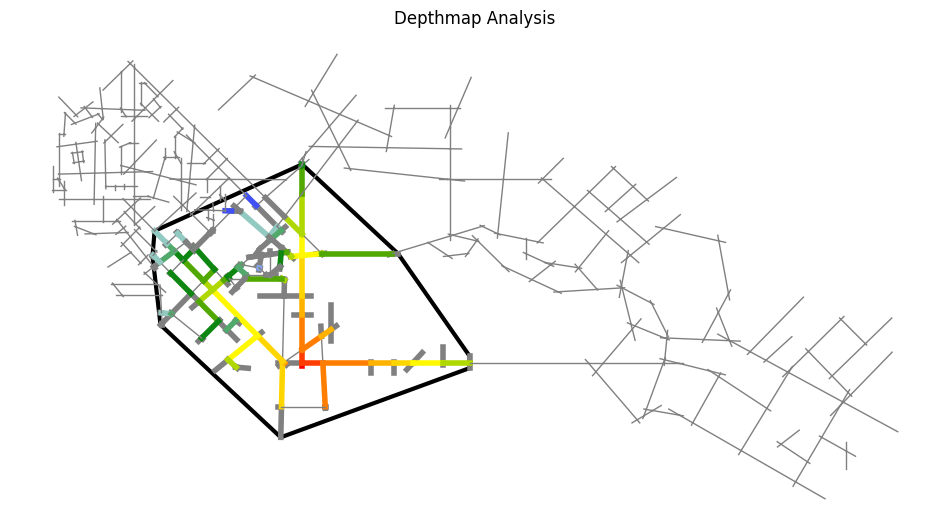

Bounding Polygon ID: 139749925588160, Area: 110131.7770787153


Please upload a DXF file.


Saving My space syntax.dxf to My space syntax (67).dxf
Processing file: My space syntax (67).dxf
DXF file My space syntax (67).dxf imported successfully.
Number of axial lines: 223
Select analysis type (axial/segment): axial
Number of axial nodes: 837
Select specific analysis (connectivity/integration/choice/depthmap) or type 'all' for all axial analyses: depthmap
Select radius type (metric/step): step
Enter the radius (in steps) for depthmap analysis: 5
Running depthmap analysis...
Number of lines found: 223


Depthmap analysis prepared for execution. Select lines and click 'Perform Depthmap Analysis'.


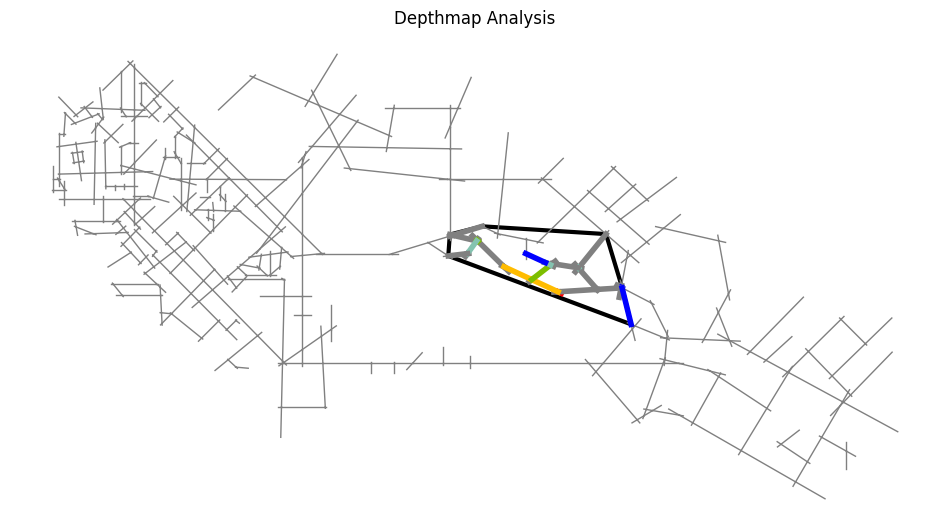

Bounding Polygon ID: 139749938204672, Area: 20381.95842022809


In [ ]:
# compled and enahnced from chat gpt 2
# perfect, the depthmap is working perfect
import ezdxf
from ezdxf import recover
from google.colab import files
import networkx as nx
import math
from shapely.geometry import LineString, Point, Polygon
from rtree import index
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import json

# Function definitions for axial and segment analysis remain unchanged
# These functions are from your provided scripts

def load_dxf(file_path):
    try:
        doc, auditor = recover.readfile(file_path)
        if auditor.has_errors:
            print(f"The DXF file {file_path} contains errors. Some data may be lost.")
        if auditor.has_fixes:
            print(f"Some errors in the DXF file {file_path} were fixed.")

        msp = doc.modelspace()
        lines = [entity for entity in msp if entity.dxftype() == 'LINE']

        if not lines:
            print(f"No lines found in the DXF file {file_path}")
            return None

        print(f"DXF file {file_path} imported successfully.")
        print(f"Number of axial lines: {len(lines)}")
        return lines
    except IOError:
        print(f"Error: Unable to read file {file_path}")
        return None
    except ezdxf.DXFStructureError as e:
        print(f"Error: Invalid or corrupted DXF file {file_path}")
        print(f"Error details: {str(e)}")
        return None

def get_2d_coords(point):
    if isinstance(point, (tuple, list)):
        return tuple(round(float(coord), 6) for coord in point[:2])
    elif hasattr(point, 'x') and hasattr(point, 'y'):
        return (round(float(point.x), 6), round(float(point.y), 6))
    else:
        raise ValueError(f"Unsupported point format: {type(point)}")

def find_all_intersections(G):
    idx = index.Index()
    intersections = {}

    edge_dict = {}
    for i, (start, end, data) in enumerate(G.edges(data=True)):
        line = data['geometry']
        idx.insert(i, line.bounds)
        edge_dict[i] = (start, end, line)

    for i, (start1, end1, line1) in edge_dict.items():
        potential_matches = list(idx.intersection(line1.bounds))

        for j in potential_matches:
            if i < j:
                start2, end2, line2 = edge_dict[j]
                if line1.intersects(line2):
                    point = line1.intersection(line2)
                    if point.geom_type == 'Point':
                        if point.coords[0] not in [line1.coords[0], line1.coords[-1], line2.coords[0], line2.coords[-1]]:
                            for edge_key, line in [((start1, end1), line1), ((start2, end2), line2)]:
                                if edge_key not in intersections:
                                    intersections[edge_key] = []
                                intersections[edge_key].append((point.x, point.y))

    return intersections

def create_graph(lines, tolerance=1e-6, min_length=1e-6):
    G = nx.Graph()
    line_id = 0
    line_mapping = {}
    for line in lines:
        start = get_2d_coords(line.dxf.start)
        end = get_2d_coords(line.dxf.end)
        length = math.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        if length >= min_length:
            angle = math.atan2(end[1] - start[1], end[0] - start[0])
            G.add_edge(start, end, weight=length, angle=angle, geometry=LineString([start, end]), id=line_id)
            G.nodes[start]['pos'] = start  # Set position for the start node
            G.nodes[end]['pos'] = end      # Set position for the end node
            line_mapping[(start, end)] = line_id
            line_id += 1
    intersections = find_all_intersections(G)
    new_edges = []
    for edge, points in intersections.items():
        start, end = edge
        line = G[start][end]['geometry']
        split_points = sorted(points, key=lambda p: line.project(Point(p)))
        split_coords = [start] + split_points + [end]
        for i in range(len(split_coords) - 1):
            new_edges.append((split_coords[i], split_coords[i + 1], G[start][end]['id']))
        G.remove_edge(start, end)
    for start, end, original_id in new_edges:
        length = math.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        if length >= min_length:
            angle = math.atan2(end[1] - start[1], end[0] - start[0])
            G.add_edge(start, end, weight=length, angle=angle, geometry=LineString([start, end]), id=original_id)
            G.nodes[start]['pos'] = start  # Set position for the start node
            G.nodes[end]['pos'] = end      # Set position for the end node
    print(f"Number of axial nodes: {len(G.nodes())}")
    return G

def calculate_connectivity(G):
    connectivity = {data['id']: 0 for u, v, data in G.edges(data=True)}
    for u, v, data in G.edges(data=True):
        connectivity[data['id']] += 1
    return connectivity

def calculate_integration(G, radius=float('inf')):
    integration = {data['id']: 0 for u, v, data in G.edges(data=True)}
    for u, v, data in G.edges(data=True):
        edge_id = data['id']
        total_depth = 0
        count = 0
        lengths = nx.single_source_shortest_path_length(G, u, cutoff=radius)
        for target, depth in lengths.items():
            if target != u:  # Exclude self-reference
                total_depth += depth
                count += 1
        if count > 0:
            mean_depth = total_depth / count
            relative_asymmetry = 2 * (mean_depth - 1) / (count - 1)
            diamond_value = (count ** 2 - 1) / (8 * (count - 1))
            real_relative_asymmetry = relative_asymmetry / diamond_value
            integration[edge_id] = 1 / real_relative_asymmetry if real_relative_asymmetry != 0 else 0
    return integration

def calculate_choice(G, radius=float('inf')):
    choice = {data['id']: 0 for u, v, data in G.edges(data=True)}
    for start in G.nodes():
        paths = nx.single_source_dijkstra_path(G, start, cutoff=radius)
        for end, path in paths.items():
            if start != end:
                for u, v in nx.utils.pairwise(path):
                    edge = tuple(sorted((u, v)))
                    if G.has_edge(u, v):
                        edge_id = G[u][v]['id']
                        choice[edge_id] += 1
    return choice

def visualize_metric(G, metric, metric_name):
    gdf = gpd.GeoDataFrame({'geometry': [G[u][v]['geometry'] for u, v in G.edges()]})
    gdf['id'] = [G[u][v]['id'] for u, v in G.edges()]
    gdf[metric_name] = gdf['id'].map(metric)

    fig, ax = plt.subplots(figsize=(12, 10))
    gdf.plot(column=metric_name, cmap='RdYlBu_r', linewidth=2, ax=ax, legend=False)
    ax.set_title(f'Axial {metric_name}')
    ax.set_axis_off()
    sm = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=plt.Normalize(vmin=gdf[metric_name].min(), vmax=gdf[metric_name].max()))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(metric_name)
    plt.show()

def save_metric_to_csv(G, metric, metric_name, file_name):
    data_list = []
    for u, v, edge_data in G.edges(data=True):
        edge_id = edge_data['id']
        edge = tuple(sorted((u, v)))
        data_list.append({'ID': edge_id, metric_name: metric.get(edge, 0)})
    df = pd.DataFrame(data_list).drop_duplicates(subset='ID')
    df.to_csv(file_name, index=False)
    files.download(file_name)

def create_segments_from_axial(G):
    segment_id = 0
    segment_mapping = {}
    segment_G = nx.Graph()

    intersections = find_all_intersections(G)

    for u, v, data in G.edges(data=True):
        line = data['geometry']
        start, end = line.coords[0], line.coords[-1]
        segments = [(start, end)]

        if (u, v) in intersections:
            for point in intersections[(u, v)]:
                point = (round(point[0], 6), round(point[1], 6))
                segments = []
                split_coords = sorted([start, point, end], key=lambda p: line.project(Point(p)))
                segments = [(split_coords[i], split_coords[i + 1]) for i in range(len(split_coords) - 1)]

        for seg_start, seg_end in segments:
            seg_length = math.sqrt((seg_end[0] - seg_start[0]) ** 2 + (seg_end[1] - seg_start[1]) ** 2)
            seg_angle = abs(math.atan2(seg_end[1] - seg_start[1], seg_end[0] - seg_start[0]))
            segment_G.add_edge(seg_start, seg_end, weight=seg_length, angle=seg_angle, geometry=LineString([seg_start, seg_end]), id=segment_id)
            segment_G.nodes[seg_start]['pos'] = seg_start
            segment_G.nodes[seg_end]['pos'] = seg_end
            segment_mapping[(seg_start, seg_end)] = segment_id
            segment_id += 1

    print(f"Number of segments: {len(segment_G.edges())}")
    return segment_G

def calculate_segment_choice(G, radius=float('inf')):
    choice = {data['id']: 0 for u, v, data in G.edges(data=True)}
    for start in G.nodes():
        paths = nx.single_source_dijkstra_path(G, start, cutoff=radius)
        for end, path in paths.items():
            if start != end:
                for u, v in nx.utils.pairwise(path):
                    if G.has_edge(u, v):
                        edge_id = G[u][v]['id']
                        choice[edge_id] += 1
    return choice

def calculate_segment_integration(G, radius=float('inf')):
    integration = {data['id']: 0 for u, v, data in G.edges(data=True)}
    for u, v, data in G.edges(data=True):
        edge_id = data['id']
        total_depth = 0
        count = 0
        lengths = nx.single_source_shortest_path_length(G, u, cutoff=radius)
        for target, depth in lengths.items():
            if target != u:
                total_depth += depth
                count += 1
        if count > 0:
            integration[edge_id] = (count ** 2) / total_depth
    return integration

def calculate_angular_weight(angle):
    if angle <= math.pi / 2:
        return angle / (math.pi / 2)
    elif angle <= math.pi:
        return 1
    else:
        return 2 - (angle / math.pi)

def calculate_angular_choice(G, radius=float('inf')):
    angular_choice = {edge: 0 for edge in G.edges()}
    for source in G.nodes():
        distances, paths = nx.single_source_dijkstra(G, source, cutoff=radius, weight='angle')
        for target in paths:
            if source != target:
                path = paths[target]
                for i in range(len(path) - 1):
                    edge = (path[i], path[i+1])
                    rev_edge = (path[i+1], path[i])
                    if edge in angular_choice:
                        target_edge = edge
                    elif rev_edge in angular_choice:
                        target_edge = rev_edge
                    else:
                        angular_choice[edge] = 0
                        target_edge = edge

                    if i > 0:
                        prev_edge = (path[i-1], path[i])
                        prev_rev_edge = (path[i], path[i-1])
                        if prev_edge in G.edges:
                            source_edge = prev_edge
                        elif prev_rev_edge in G.edges:
                            source_edge = prev_rev_edge
                        else:
                            continue

                        angle = abs(G.edges[source_edge]['angle'] - G.edges[target_edge]['angle'])
                        weight = calculate_angular_weight(angle)
                        angular_choice[target_edge] += weight
                    else:
                        angular_choice[target_edge] += 1
    return angular_choice

def calculate_angular_integration(G, radius=float('inf')):
    angular_integration = {data['id']: 0 for u, v, data in G.edges(data=True)}
    for u, v, data in G.edges(data=True):
        edge_id = data['id']
        total_angular_depth = 0
        count = 0
        lengths = nx.single_source_dijkstra_path_length(G, u, weight='angle', cutoff=radius)
        for target, depth in lengths.items():
            if target != u:
                total_angular_depth += depth
                count += 1
        if count > 0:
            mean_angular_depth = total_angular_depth / count
            angular_integration[edge_id] = count / mean_angular_depth
    return angular_integration

def calculate_normalized_segment_choice(G, radius=float('inf')):
    choice = calculate_segment_choice(G, radius)
    total_depth = {node: 0 for node in G.nodes()}
    for node in G.nodes():
        lengths = nx.single_source_shortest_path_length(G, node, cutoff=radius)
        for target, depth in lengths.items():
            total_depth[target] += depth

    nach = {}
    for edge in G.edges():
        u, v = edge
        edge_id = G[u][v]['id']
        ch = choice.get(edge_id, 0)
        td_u = total_depth.get(u, 0)
        td_v = total_depth.get(v, 0)

        if ch == 0 or td_u == 0 or td_v == 0:
            nach[edge_id] = 0
        else:
            try:
                td_avg = (td_u + td_v) / 2
                nach[edge_id] = math.log(ch + 1) / math.log(td_avg + 3)
            except ValueError as e:
                nach[edge_id] = 0

    return nach

def calculate_normalized_segment_integration(G, radius=float('inf')):
    integration = calculate_segment_integration(G, radius)
    min_integration = min(integration.values())
    max_integration = max(integration.values())

    if min_integration == max_integration:
        normalized_integration = {edge_id: 1 for edge_id in integration.keys()}
    else:
        normalized_integration = {edge_id: (value - min_integration) / (max_integration - min_integration)
                                  for edge_id, value in integration.items()}

    return normalized_integration

def visualize_metric_interactive(G, metric, metric_name, radius, use_slider=False):
    gdf = gpd.GeoDataFrame({'geometry': [G.edges[edge]['geometry'] for edge in G.edges()]})
    gdf['id'] = [G.edges[edge]['id'] for edge in G.edges()]
    gdf['value'] = gdf['id'].map(metric)

    output = widgets.Output()

    def plot_map(vmin, vmax):
        with output:
            clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(12, 10))
            norm = colors.Normalize(vmin=vmin, vmax=vmax)
            gdf.plot(column='value', cmap='RdYlBu_r', linewidth=2, ax=ax, legend=True, norm=norm)
            ax.set_title(f'{metric_name} (Radius: {radius})')
            ax.set_axis_off()
            plt.show()

    if use_slider:
        vmin_slider = widgets.FloatSlider(
            value=gdf['value'].min(),
            min=gdf['value'].min(),
            max=gdf['value'].max(),
            step=0.1,
            description='vmin',
        )
        vmax_slider = widgets.FloatSlider(
            value=gdf['value'].max(),
            min=gdf['value'].min(),
            max=gdf['value'].max(),
            step=0.1,
            description='vmax',
        )

        def update_plot(change):
            vmin = vmin_slider.value
            vmax = vmax_slider.value
            if vmin <= vmax:
                plot_map(vmin, vmax)

        vmin_slider.observe(update_plot, names='value')
        vmax_slider.observe(update_plot, names='value')

        ui = widgets.VBox([widgets.Label(f'{metric_name} (Radius: {radius})'), vmin_slider, vmax_slider])
        display(ui, output)
        plot_map(vmin_slider.value, vmax_slider.value)
    else:
        plot_map(gdf['value'].min(), gdf['value'].max())
        display(output)

def save_combined_metric_to_csv(G, metrics, metric_names, file_name):
    data_list = []
    for u, v, edge_data in G.edges(data=True):
        edge_id = edge_data['id']
        data = {'ID': edge_id}
        for metric_name, metric in zip(metric_names, metrics):
            data[metric_name] = metric.get(edge_id, 0)
        data_list.append(data)
    df = pd.DataFrame(data_list)
    df.to_csv(file_name, index=False)
    files.download(file_name)

# New depthmap function
import math
# Define necessary functions
def calculate_length(start, end):
    return math.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)


def display_dxf_vector_lines(lines_info):
    # Calculate bounds manually
    minx = miny = float('inf')
    maxx = maxy = float('-inf')

    for line_info in lines_info:
        start = Point(line_info['start'])
        end = Point(line_info['end'])
        minx = min(minx, start.x, end.x)
        miny = min(miny, start.y, end.y)
        maxx = max(maxx, start.x, end.x)
        maxy = max(maxy, start.y, end.y)

    lines_count = len(lines_info)
    print(f"Number of lines found: {lines_count}")

    # If no lines found, set default values
    if (minx == float('inf')) or (maxx == float('-inf')) or (miny == float('inf')) or (maxy == float('-inf')):
        minx = miny = 0
        maxx = maxy = 1000

    # Add some padding
    padding = max((maxx - minx), (maxy - miny)) * 0.05  # 5% padding
    minx -= padding
    miny -= padding
    maxx += padding
    maxy += padding

    width = maxx - minx
    height = maxy - miny

    # Maintain aspect ratio
    aspect_ratio = width / height

    # Prepare SVG content with corrected coordinate system
    svg_content = f'''
    <div id="svg-container">
    <svg width="{800}" height="{800 / aspect_ratio}" viewBox="{minx} {-maxy} {width} {height}"
         xmlns="http://www.w3.org/2000/svg">
    <g transform="scale(1,-1)">
    '''

    # Draw lines
    for line_info in lines_info:
        svg_content += f'<line id="{line_info["id"]}" x1="{line_info["start"][0]}" y1="{line_info["start"][1]}" x2="{line_info["end"][0]}" y2="{line_info["end"][1]}" stroke="blue" stroke-width="2"/>'

    svg_content += '''
    </g>
    </svg>
    </div>
    <div id="debug-info"></div>
    <button onclick="displaySelectedLinesInfo()">Show Selected Lines Info</button>
    <button id="performDepthmapAnalysis">Perform Depthmap Analysis</button>
    <div id="lines-info-table"></div>
    '''

    # CSS for interactivity
    css = '''
    <style>
    #svg-container line {
        cursor: pointer;
    }
    #svg-container svg * {
        pointer-events: all;
    }
    #debug-info {
        margin-top: 10px;
        padding: 10px;
        border: 1px solid #ccc;
        background-color: #f0f0f0;
    }
    #lines-info-table table {
        width: 100%;
        border-collapse: collapse;
    }
    #lines-info-table table, #lines-info-table th, #lines-info-table td {
        border: 1px solid black;
    }
    #lines-info-table th, #lines-info-table td {
        padding: 8px;
        text-align: left;
    }
    </style>
    '''

    # JavaScript for interactivity
    js_code = f'''
    <script>
    var selectedLines = [];

    function initSVGInteraction() {{
        var svg = document.querySelector('#svg-container svg');
        var debugInfo = document.getElementById('debug-info');

        svg.addEventListener('click', function(event) {{
            var target = event.target;
            if (target.tagName.toLowerCase() === 'line') {{
                var currentColor = target.getAttribute('stroke');
                var newColor = (currentColor === 'blue') ? 'yellow' : 'blue';
                var newWidth = (currentColor === 'blue') ? '4' : '2';

                target.setAttribute('stroke', newColor);
                target.setAttribute('stroke-width', newWidth);

                var lineId = target.id;
                if (newColor === 'yellow') {{
                    selectedLines.push(lineId);
                }} else {{
                    var index = selectedLines.indexOf(lineId);
                    if (index > -1) {{
                        selectedLines.splice(index, 1);
                    }}
                }}

                debugInfo.innerHTML = 'Line clicked: ' + lineId +
                                      ', New color: ' + newColor +
                                      ', New width: ' + newWidth;
            }} else {{
                debugInfo.innerHTML = 'Clicked on non-line element: ' + target.tagName;
            }}
        }});

        debugInfo.innerHTML = 'SVG is ready. Click on lines to change their colors!';
    }}

    function displaySelectedLinesInfo() {{
        var linesInfo = {json.dumps(lines_info)};
        var selectedInfo = linesInfo.filter(line => selectedLines.includes(line.id));
        var tableHTML = '<table><tr><th>ID</th><th>Length</th></tr>';

        selectedInfo.forEach(function(line) {{
            tableHTML += '<tr><td>' + line.id + '</td><td>' + line.length.toFixed(2) + '</td></tr>';
        }});

        tableHTML += '</table>';
        document.getElementById('lines-info-table').innerHTML = tableHTML;
    }}

    function performDepthmapAnalysis() {{
        google.colab.kernel.invokeFunction('notebook.PerformDepthmapAnalysis', [selectedLines], {{}});
    }}

    document.getElementById('performDepthmapAnalysis').addEventListener('click', performDepthmapAnalysis);

    setTimeout(initSVGInteraction, 1000);
    </script>
    '''

    display(HTML(css + svg_content + js_code))


# Depthmap analysis function

"""
from shapely.geometry import MultiPoint
import matplotlib.colors as mcolors

def perform_depthmap_analysis(selected_lines, lines_info, radius, G):
    selected_lines_coords = []
    for line_id in selected_lines:
        line_info = next((line for line in lines_info if line['id'] == line_id), None)
        if line_info:
            selected_lines_coords.append((line_info['start'], line_info['end']))

    paths = []
    for start, end in selected_lines_coords:
        lengths, path_dict = nx.single_source_dijkstra(G, start, cutoff=radius)
        for path in path_dict.values():
            paths.append(path)

    # Assign colors based on distance from base lines
    distances = {}
    for path in paths:
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            edge = (u, v)
            rev_edge = (v, u)
            if edge in distances:
                distances[edge] += 1
            elif rev_edge in distances:
                distances[rev_edge] += 1
            else:
                distances[edge] = 1

    max_distance = max(distances.values())
    min_distance = min(distances.values())

    # Create a custom color map with specified colors
    colors_list = ['red', 'orange', 'yellow', 'green', 'lightblue', 'blue']
    custom_color_map = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors_list)

    # Normalize the distances for color mapping
    norm = mcolors.Normalize(vmin=min_distance, vmax=max_distance)

    # Generate the color gradient for the lines
    colors = {}
    for edge, distance in distances.items():
        norm_distance = norm(distance)
        colors[edge] = custom_color_map(norm_distance)

    # Find the furthest endpoints
    furthest_endpoints = [point for path in paths for point in path[-1:]]

    # Create a convex hull to ensure a proper non-self-intersecting polygon
    hull = MultiPoint(furthest_endpoints).convex_hull

    # Visualize results with preserved aspect ratio and adjusted line widths
    fig, ax = plt.subplots(figsize=(12, 10))
    for u, v, data in G.edges(data=True):
        line = data['geometry']
        color = colors.get((u, v), 'gray')  # Default color for unselected lines
        width = 4 if (u, v) in colors or (v, u) in colors else 1  # Thicker for selected, thinner for unselected
        ax.plot(*line.xy, color=color, linewidth=width)

    ax.add_patch(plt.Polygon(hull.exterior.coords, closed=True, fill=None, edgecolor='black', linewidth=3))
    ax.set_title('Depthmap Analysis')
    ax.set_aspect('equal', 'box')  # Preserve aspect ratio
    ax.set_axis_off()
    plt.show()

    print(f"Bounding Polygon ID: {id(hull)}, Area: {hull.area}")
"""
from shapely.geometry import MultiPoint
import matplotlib.colors as mcolors
import numpy as np


def perform_depthmap_analysis(selected_lines, lines_info, radius, G, radius_type):
    selected_lines_coords = []
    for line_id in selected_lines:
        line_info = next((line for line in lines_info if line['id'] == line_id), None)
        if line_info:
            selected_lines_coords.append((line_info['start'], line_info['end']))

    paths = []
    if radius_type == 'metric':
        for start, end in selected_lines_coords:
            lengths, path_dict = nx.single_source_dijkstra(G, start, cutoff=radius)
            for path in path_dict.values():
                paths.append(path)
    elif radius_type == 'step':
        for start, end in selected_lines_coords:
            paths.extend(nx.single_source_shortest_path(G, start, cutoff=radius).values())

    # Assign colors based on distance from base lines
    distances = {}
    for path in paths:
        for i in range(len(path) - 1):
            u, v = path[i], path[i+1]
            edge = (u, v)
            rev_edge = (v, u)
            if edge in distances:
                distances[edge] = min(distances[edge], len(path))
            elif rev_edge in distances:
                distances[rev_edge] = min(distances[rev_edge], len(path))
            else:
                distances[edge] = len(path)

    max_distance = max(distances.values())
    min_distance = min(distances.values())

    # Create a custom color map with specified colors
    colors_list = ['red', 'orange', 'yellow', 'green', 'lightblue', 'blue']
    custom_color_map = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors_list)

    # Normalize the distances for color mapping
    norm = mcolors.Normalize(vmin=min_distance, vmax=max_distance)

    # Generate the color gradient for the lines
    colors = {}
    for edge, distance in distances.items():
        norm_distance = norm(distance)
        colors[edge] = custom_color_map(norm_distance)

    # Find the furthest endpoints
    furthest_endpoints = [point for path in paths for point in path[-1:]]

    # Create a convex hull to ensure a proper non-self-intersecting polygon
    hull = MultiPoint(furthest_endpoints).convex_hull

    # Visualize results with preserved aspect ratio and adjusted line widths
    fig, ax = plt.subplots(figsize=(12, 10))
    for u, v, data in G.edges(data=True):
        line = data['geometry']
        color = colors.get((u, v), 'gray')  # Default color for unselected lines
        width = 4 if (u, v) in colors or (v, u) in colors else 1  # Thicker for selected, thinner for unselected
        ax.plot(*line.xy, color=color, linewidth=width)

    ax.add_patch(plt.Polygon(hull.exterior.coords, closed=True, fill=None, edgecolor='black', linewidth=3))
    ax.set_title('Depthmap Analysis')
    ax.set_aspect('equal', 'box')  # Preserve aspect ratio
    ax.set_axis_off()
    plt.show()

    print(f"Bounding Polygon ID: {id(hull)}, Area: {hull.area}")


# Main function extension for depthmap analysis
def main():
    print("Please upload a DXF file.")
    uploaded = files.upload()
    if not uploaded:
        print("No file was uploaded. Exiting.")
        return
    file_name = next(iter(uploaded))
    print(f"Processing file: {file_name}")
    with open(file_name, 'wb') as f:
        f.write(uploaded[file_name])
    lines = load_dxf(file_name)
    if lines is None:
        return

    lines_info = []
    for i, line in enumerate(lines):
        start = get_2d_coords(line.dxf.start)
        end = get_2d_coords(line.dxf.end)
        length = calculate_length(line.dxf.start, line.dxf.end)
        lines_info.append({'id': f'line_{i}', 'length': length, 'start': start, 'end': end})

    analysis_type = input("Select analysis type (axial/segment): ").lower()
    if analysis_type == 'axial':
        G = create_graph(lines)
        specific_analysis = input("Select specific analysis (connectivity/integration/choice/depthmap) or type 'all' for all axial analyses: ").lower()
        metrics = []
        metric_names = []

        if specific_analysis == 'connectivity' or specific_analysis == 'all':
            print("Calculating connectivity...")
            connectivity = calculate_connectivity(G)
            conn_values = list(connectivity.values())
            print(f"Connectivity stats: Min={min(conn_values)}, Max={max(conn_values)}, Mean={sum(conn_values)/len(conn_values):.2f}")
            visualize_metric_interactive(G, connectivity, 'connectivity', radius='N/A', use_slider=(specific_analysis != 'all'))
            metrics.append(connectivity)
            metric_names.append('connectivity')
            if specific_analysis != 'all':
                save_metric_to_csv(G, connectivity, 'connectivity', 'connectivity_analysis.csv')
                print("Axial analysis with connectivity completed.")

        if specific_analysis == 'integration' or specific_analysis == 'all':
            radius = input("Enter the radius (in meters) for integration calculation (or 'Rn' for maximum radius): ")
            radius = float('inf') if radius.lower() == 'rn' else float(radius)
            print("Calculating integration...")
            integration = calculate_integration(G, radius)
            int_values = list(integration.values())
            print(f"Integration stats: Min={min(int_values):.4f}, Max={max(int_values):.4f}, Mean={sum(int_values)/len(int_values):.4f}")
            visualize_metric_interactive(G, integration, 'integration', radius, use_slider=(specific_analysis != 'all'))
            metrics.append(integration)
            metric_names.append('integration')
            if specific_analysis != 'all':
                save_metric_to_csv(G, integration, 'integration', 'integration_analysis.csv')
                print("Axial analysis with integration completed.")

        if specific_analysis == 'choice' or specific_analysis == 'all':
            radius = input("Enter the radius (in meters) for choice calculation (or 'Rn' for maximum radius): ")
            radius = float('inf') if radius.lower() == 'rn' else float(radius)
            print("Calculating choice...")
            choice = calculate_choice(G, radius)
            choice_values = list(choice.values())
            print(f"Choice stats: Min={min(choice_values):.4f}, Max={max(choice_values):.4f}, Mean={sum(choice_values)/len(choice_values):.4f}")
            visualize_metric_interactive(G, choice, 'choice', radius, use_slider=(specific_analysis != 'all'))
            metrics.append(choice)
            metric_names.append('choice')
            if specific_analysis != 'all':
                save_metric_to_csv(G, choice, 'choice', 'choice_analysis.csv')
                print("Axial analysis with choice completed.")

        if specific_analysis == 'depthmap' or specific_analysis == 'all':
            global selected_lines_info, G_global
            selected_lines_info = lines_info  # Ensure lines_info is globally accessible for callback
            G_global = G  # Ensure G is globally accessible for callback
            radius_type = input("Select radius type (metric/step): ").lower()
            if radius_type == 'metric':
                radius = float(input("Enter the radius (in meters) for depthmap analysis: "))
            elif radius_type == 'step':
                radius = int(input("Enter the radius (in steps) for depthmap analysis: "))
            else:
                print("Invalid radius type. Exiting.")
                return
            print("Running depthmap analysis...")
            display_dxf_vector_lines(lines_info)
            # Invoke depthmap analysis after the user selects lines
            output.register_callback('notebook.PerformDepthmapAnalysis', lambda selected_lines: perform_depthmap_analysis(selected_lines, selected_lines_info, radius, G_global, radius_type))
            print("Depthmap analysis prepared for execution. Select lines and click 'Perform Depthmap Analysis'.")

        if specific_analysis == 'all':
            save_combined_metric_to_csv(G, metrics, metric_names, 'all_axial_analyses.csv')
            print("All axial analyses completed and saved in a single CSV file.")

    elif analysis_type == 'segment':
        G = create_graph(lines)
        segment_G = create_segments_from_axial(G)
        specific_analysis = input("Select specific analysis (choice/integration/angular_choice/angular_integration/normalized_choice/normalized_integration) or type 'all' for all segment analyses: ").lower()
        metrics = []
        metric_names = []

        if specific_analysis == 'choice' or specific_analysis == 'all':
            radius = input("Enter the radius (in meters) for choice calculation (or 'Rn' for maximum radius): ")
            radius = float('inf') if radius.lower() == 'rn' else float(radius)
            print("Calculating segment choice...")
            segment_choice = calculate_segment_choice(segment_G, radius)
            choice_values = list(segment_choice.values())
            print(f"Segment choice stats: Min={min(choice_values):.4f}, Max={max(choice_values):.4f}, Mean={sum(choice_values)/len(choice_values):.4f}")
            visualize_metric_interactive(segment_G, segment_choice, 'segment_choice', radius, use_slider=(specific_analysis != 'all'))
            metrics.append(segment_choice)
            metric_names.append('segment_choice')
            if specific_analysis != 'all':
                save_metric_to_csv(segment_G, segment_choice, 'segment_choice', 'segment_choice_analysis.csv')
                print("Segment analysis with choice completed.")

        if specific_analysis == 'integration' or specific_analysis == 'all':
            radius = input("Enter the radius (in meters) for integration calculation (or 'Rn' for maximum radius): ")
            radius = float('inf') if radius.lower() == 'rn' else float(radius)
            print("Calculating segment integration...")
            segment_integration = calculate_segment_integration(segment_G, radius)
            int_values = list(segment_integration.values())
            print(f"Segment integration stats: Min={min(int_values):.4f}, Max={max(int_values):.4f}, Mean={sum(int_values)/len(int_values):.4f}")
            visualize_metric_interactive(segment_G, segment_integration, 'segment_integration', radius, use_slider=(specific_analysis != 'all'))
            metrics.append(segment_integration)
            metric_names.append('segment_integration')
            if specific_analysis != 'all':
                save_metric_to_csv(segment_G, segment_integration, 'segment_integration', 'segment_integration_analysis.csv')
                print("Segment analysis with integration completed.")

        if specific_analysis == 'angular_choice' or specific_analysis == 'all':
            radius = input("Enter the radius (in meters) for angular choice calculation (or 'Rn' for maximum radius): ")
            radius = float('inf') if radius.lower() == 'rn' else float(radius)
            print("Calculating angular choice...")
            angular_choice = calculate_angular_choice(segment_G, radius)
            ang_choice_values = list(angular_choice.values())
            print(f"Angular choice stats: Min={min(ang_choice_values):.4f}, Max={max(ang_choice_values):.4f}, Mean={sum(ang_choice_values)/len(ang_choice_values):.4f}")
            visualize_metric_interactive(segment_G, angular_choice, 'angular_choice', radius, use_slider=(specific_analysis != 'all'))
            metrics.append(angular_choice)
            metric_names.append('angular_choice')
            if specific_analysis != 'all':
                save_metric_to_csv(segment_G, angular_choice, 'angular_choice', 'angular_choice_analysis.csv')
                print("Segment analysis with angular choice completed.")

        if specific_analysis == 'angular_integration' or specific_analysis == 'all':
            radius = input("Enter the radius (in meters) for angular integration calculation (or 'Rn' for maximum radius): ")
            radius = float('inf') if radius.lower() == 'rn' else float(radius)
            print("Calculating angular integration...")
            angular_integration = calculate_angular_integration(segment_G, radius)
            ang_int_values = list(angular_integration.values())
            print(f"Angular integration stats: Min={min(ang_int_values):.4f}, Max={max(ang_int_values):.4f}, Mean={sum(ang_int_values)/len(ang_int_values):.4f}")
            visualize_metric_interactive(segment_G, angular_integration, 'angular_integration', radius, use_slider=(specific_analysis != 'all'))
            metrics.append(angular_integration)
            metric_names.append('angular_integration')
            if specific_analysis != 'all':
                save_metric_to_csv(segment_G, angular_integration, 'angular_integration', 'angular_integration_analysis.csv')
                print("Segment analysis with angular integration completed.")

        if specific_analysis == 'normalized_choice' or specific_analysis == 'all':
            radius = input("Enter the radius (in meters) for normalized choice calculation (or 'Rn' for maximum radius): ")
            radius = float('inf') if radius.lower() == 'rn' else float(radius)
            print("Calculating normalized angular choice (NACH)...")
            normalized_segment_choice = calculate_normalized_segment_choice(segment_G, radius)
            nach_values = list(normalized_segment_choice.values())
            if len(nach_values) > 0:
                print(f"NACH stats: Min={min(nach_values):.4f}, Max={max(nach_values):.4f}, Mean={sum(nach_values)/len(nach_values):.4f}")
                visualize_metric_interactive(segment_G, normalized_segment_choice, 'NACH', radius, use_slider=(specific_analysis != 'all'))
                metrics.append(normalized_segment_choice)
                metric_names.append('NACH')
                if specific_analysis != 'all':
                    save_metric_to_csv(segment_G, normalized_segment_choice, 'NACH', 'nach_analysis.csv')
                    print("Segment analysis with NACH completed.")
            else:
                print("Error: No valid NACH values calculated.")

        if specific_analysis == 'normalized_integration' or specific_analysis == 'all':
            radius = input("Enter the radius (in meters) for normalized integration calculation (or 'Rn' for maximum radius): ")
            radius = float('inf') if radius.lower() == 'rn' else float(radius)
            print("Calculating normalized segment integration...")
            normalized_segment_integration = calculate_normalized_segment_integration(segment_G, radius)
            norm_int_values = list(normalized_segment_integration.values())
            print(f"Normalized integration stats: Min={min(norm_int_values):.4f}, Max={max(norm_int_values):.4f}, Mean={sum(norm_int_values)/len(norm_int_values):.4f}")
            visualize_metric_interactive(segment_G, normalized_segment_integration, 'normalized_segment_integration', radius, use_slider=(specific_analysis != 'all'))
            metrics.append(normalized_segment_integration)
            metric_names.append('normalized_segment_integration')
            if specific_analysis != 'all':
                save_metric_to_csv(segment_G, normalized_segment_integration, 'normalized_segment_integration', 'normalized_segment_integration_analysis.csv')
                print("Segment analysis with normalized integration completed.")

        if specific_analysis == 'all':
            print("Calculating all segment analyses...")

            segment_choice = calculate_segment_choice(segment_G, float('inf'))
            metrics.append(segment_choice)
            metric_names.append('segment_choice')

            segment_integration = calculate_segment_integration(segment_G, float('inf'))
            metrics.append(segment_integration)
            metric_names.append('segment_integration')

            angular_choice = calculate_angular_choice(segment_G, float('inf'))
            metrics.append(angular_choice)
            metric_names.append('angular_choice')

            angular_integration = calculate_angular_integration(segment_G, float('inf'))
            metrics.append(angular_integration)
            metric_names.append('angular_integration')

            normalized_segment_choice = calculate_normalized_segment_choice(segment_G, float('inf'))
            metrics.append(normalized_segment_choice)
            metric_names.append('normalized_segment_choice')

            normalized_segment_integration = calculate_normalized_segment_integration(segment_G, float('inf'))
            metrics.append(normalized_segment_integration)
            metric_names.append('normalized_segment_integration')

            save_combined_metric_to_csv(segment_G, metrics, metric_names, 'all_segment_analyses.csv')
            print("All segment analyses completed and saved in a single CSV file.")

            for metric, name in zip(metrics, metric_names):
                visualize_metric_interactive(segment_G, metric, name, radius='Rn', use_slider=False)

    else:
        print("Invalid analysis type. Exiting.")

# Register the callback function for depthmap analysis
def callback_depthmap_analysis(selected_lines):
    global selected_lines_info, G_global, radius, radius_type
    perform_depthmap_analysis(selected_lines, selected_lines_info, radius, G_global, radius_type)

output.register_callback('notebook.PerformDepthmapAnalysis', callback_depthmap_analysis)

if __name__ == "__main__":
    main()